In [25]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [5]:
# load data
data_path = "../data/depression.csv"
data = pd.read_csv(data_path)

In [37]:
data.shape

(970, 186)

In [42]:
data = data.dropna(axis=1)

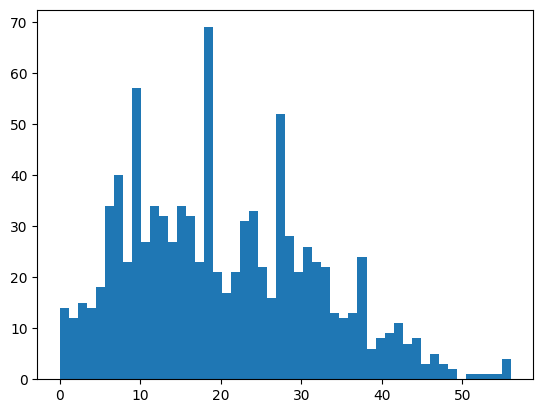

In [57]:
plt.hist(data["cesd_total"], bins=50)
plt.show()

/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ucloud/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


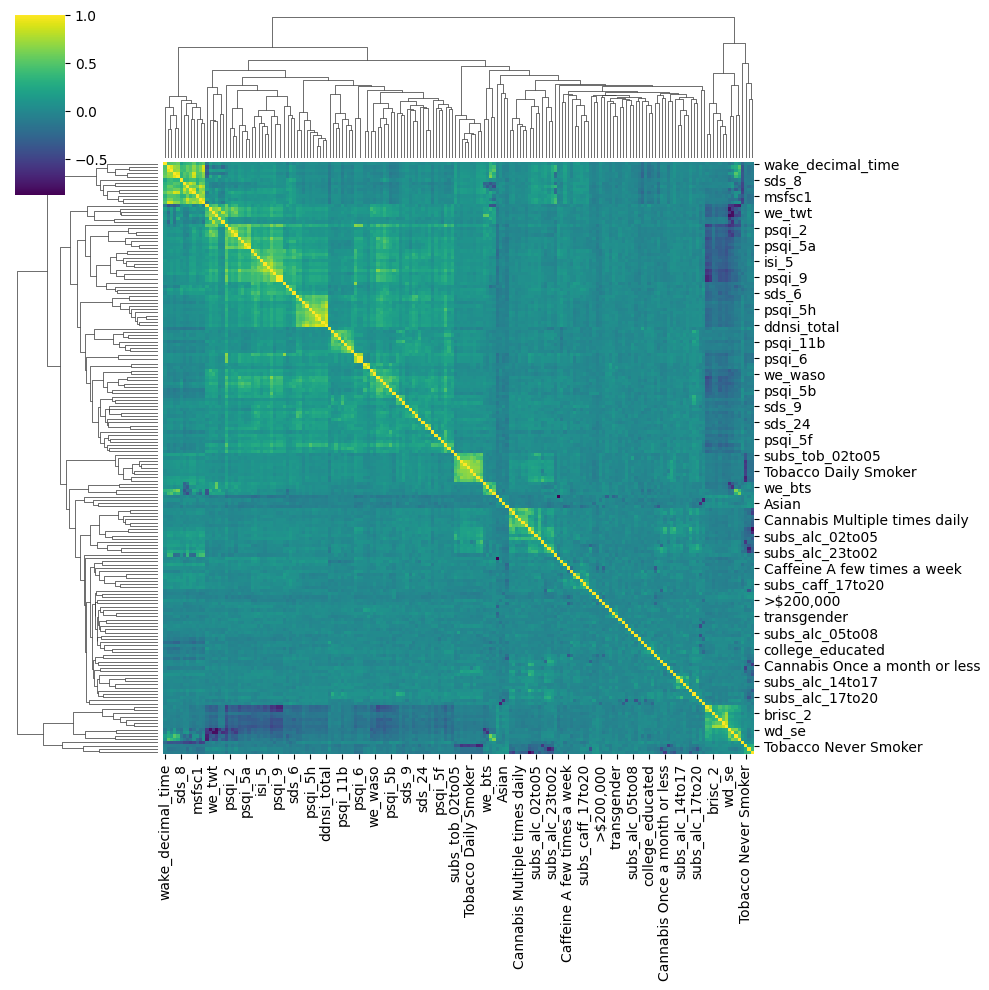

In [43]:
sns.clustermap(data.corr(), cmap='viridis')
plt.show()

In [44]:
X = data.iloc[:,:181].values
y = data.iloc[:,182].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [47]:
# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

In [48]:
def identify_variable_types(data):
    continuous_vars = []
    dummy_vars = []

    num_columns = data.shape[1]
    
    for i in range(num_columns):
        unique_values = np.unique(data[:, i])
        if len(unique_values) == 2 and np.array_equal(unique_values, [0, 1]):
            dummy_vars.append(i)
        else:
            continuous_vars.append(i)
    
    return continuous_vars, dummy_vars

In [49]:
continuous_cols_train, dummy_cols_train = identify_variable_types(X_train)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_train),
        ('dummy', 'passthrough', dummy_cols_train)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_train = preprocessor.fit_transform(X_train)

In [50]:
continuous_cols_val, dummy_cols_val = identify_variable_types(X_val)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_val),
        ('dummy', 'passthrough', dummy_cols_val)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_val = preprocessor.fit_transform(X_val)

In [51]:
continuous_cols_test, dummy_cols_test = identify_variable_types(X_test)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols_test),
        ('dummy', 'passthrough', dummy_cols_test)  # Leave dummy variables unchanged or use StandardScaler() if needed
    ]
)

# Fit and transform the data
X_test = preprocessor.fit_transform(X_test)

In [52]:
performances = []

In [34]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [53]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=None, 
             X=x, y=y, 
             nsplit=nsplit, 
             model_name='dummy', 
             constant_value=y_train.mean())

In [54]:
reg = LinearRegression().fit(X_train, y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    evaluate(model=reg, 
                X=x, y=y, 
                nsplit=nsplit, 
                model_name=f'linear')

In [59]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train, X_val, X_test],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

In [63]:
perf_df_filtered = perf_df[perf_df['model'] != 'linear']

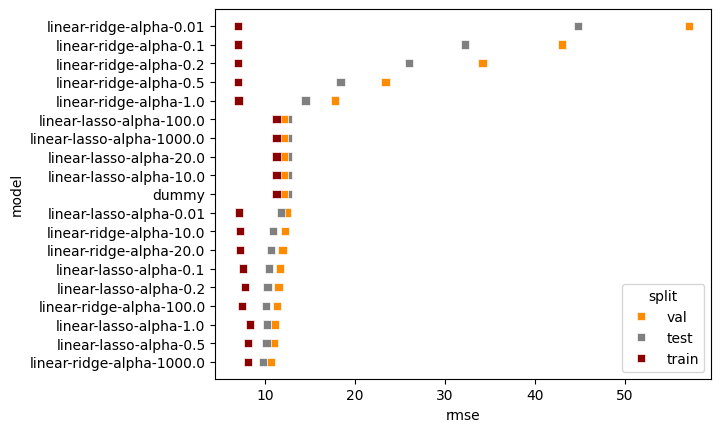

In [65]:
#perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df_filtered.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [67]:
coefs = pd.DataFrame(np.vstack([v.coef_.round(4) for v in models.values()]),
                     columns=data.iloc[:,:181].columns)
coefs['mtype'] = [k.split('-')[0] for k in models.keys()]
coefs['alpha'] = [float(k.split('-')[1]) for k in models.keys()]
coefs = pd.melt(coefs, id_vars=['mtype', 'alpha'])# turning data into long format 

grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")
